In [1]:
import os
import gc
import json
import unidecode
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import VGG19_Weights

import optuna
import wandb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from datetime import datetime

import import_ipynb

######## 

from DATA_AND_MODELS import VanGoghDataset,VanGoghModel

wandb.login(key='ba8ed449ca151ad3f490026aec87d75b7171a16d')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/gabriel/.netrc
wandb: Currently logged in as: gabi-dadashev (gabi-dadashev-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
def early_stop_check(patience, best_val_loss, best_val_loss_epoch, current_val_loss, current_val_loss_epoch):
    early_stop_flag = False  
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_val_loss_epoch = current_val_loss_epoch
    else:
        if current_val_loss_epoch - best_val_loss_epoch > patience:
            early_stop_flag = True  
    return best_val_loss, best_val_loss_epoch, early_stop_flag


In [3]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
    print('train_model_with_hyperparams')
    
    best_val_loss = float('inf')
    best_val_loss_epoch = 0  
    early_stop_flag = False
    best_model_state = None  

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1s = []
    val_aucs = []

    for epoch in range(1, epochs + 1):
        
        ### Training Loop
        model.train() 
        epoch_train_loss = 0.0 
        total_train_samples = 0 
        correct_train_predictions = 0 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            
            outputs = model(inputs).squeeze(1)  
            loss = criterion(outputs.view(-1), labels)
            loss.backward() 
            optimizer.step()  

            epoch_train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)
            
            preds_train = (outputs > 0.5).float()
            correct_train_predictions += (preds_train == labels).sum().item()

        epoch_train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ### Validation Loop
        model.eval()  
        epoch_val_loss = 0.0 
        total_val_samples = 0 
        correct_val_predictions = 0

        all_val_labels = []
        all_val_preds = []
        all_val_probs = []

        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)  # outputs shape: (batch_size)
                loss = criterion(outputs.view(-1), labels)

                epoch_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)
                
                preds = (outputs > 0.5).float()
                
                correct_val_predictions += (preds == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(outputs.cpu().numpy())

        epoch_val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples

        if len(np.unique(all_val_labels)) > 1:
            val_f1 = f1_score(all_val_labels, all_val_preds)
            val_auc = roc_auc_score(all_val_labels, all_val_probs)
        else:
            val_f1 = 0
            val_auc = 0

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        best_val_loss, best_val_loss_epoch, early_stop_flag = early_stop_check(patience, best_val_loss, best_val_loss_epoch, epoch_val_loss, epoch)
        if epoch_val_loss == best_val_loss:
            best_model_state = model.state_dict()

        print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}, Val F1 = {val_f1:.4f}, Val AUC = {val_auc:.4f}")

        if early_stop_flag: 
            break 

    if best_model_state is not None: 
        now = datetime.now()
        torch.save(best_model_state, f"best_model_trial_{now.strftime('%H:%M:%S')}.pt") 

    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, val_f1s, label="Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_aucs, label="Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_val_loss


In [4]:
classes = pd.read_csv("classes.csv", encoding="utf-8")
classes=classes[['filename', 'artist', 'genre', 'description', 'phash', 'width','height', 'genre_count']].copy()
classes_only_post_impressionism = classes[classes["filename"].str.contains('Post_Impressionism', case=False, na=False)].copy()
classes_only_post_impressionism['is_van_gogh'] = np.where(classes_only_post_impressionism['artist'] == 'vincent van gogh', 1, 0)
classes_only_post_impressionism=classes_only_post_impressionism.reset_index(drop=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [5]:
dataset = VanGoghDataset(dataframe=classes_only_post_impressionism)


***Train VGG19***

--- Fold 1/5 ---


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6934, Val Loss = 0.6868, Train Acc = 0.8422, Val Acc = 0.8653, Val F1 = 0.2130, Val AUC = 0.7530
Epoch 2: Train Loss = 0.6826, Val Loss = 0.6846, Train Acc = 0.8743, Val Acc = 0.8708, Val F1 = 0.2557, Val AUC = 0.8522
Epoch 3: Train Loss = 0.6783, Val Loss = 0.6769, Train Acc = 0.8840, Val Acc = 0.8994, Val F1 = 0.5575, Val AUC = 0.8915
Epoch 4: Train Loss = 0.6724, Val Loss = 0.6799, Train Acc = 0.9021, Val Acc = 0.8827, Val F1 = 0.3729, Val AUC = 0.9061
Epoch 5: Train Loss = 0.6709, Val Loss = 0.6724, Train Acc = 0.9033, Val Acc = 0.9081, Val F1 = 0.6000, Val AUC = 0.9054
Epoch 6: Train Loss = 0.6694, Val Loss = 0.6818, Train Acc = 0.9058, Val Acc = 0.9057, Val F1 = 0.6893, Val AUC = 0.9148
Epoch 7: Train Loss = 0.6687, Val Loss = 0.6675, Train Acc = 0.9160, Val Acc = 0.9295, Val F1 = 0.7375, Val AUC = 0.9291
Epoch 8: Train Loss = 0.6681, Val Loss = 0.6802, Train Acc = 0.9156, Val Acc = 0.8859, Val F1 = 0.4375, Val AUC = 0.8683
Epo

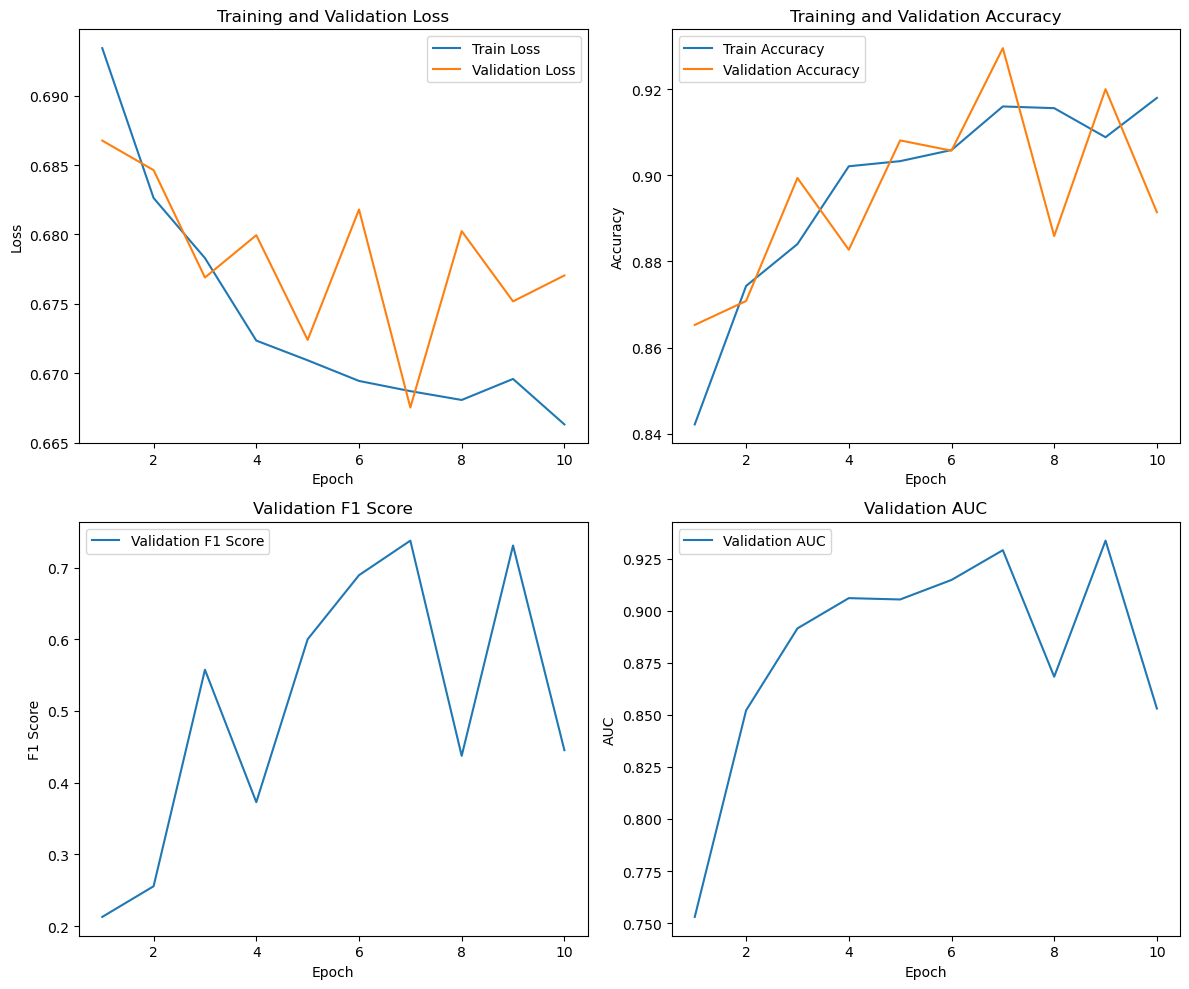

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66753
fold,1
val_accuracy,0.89065
val_auc,0.8732
val_f1,0.43902


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6937, Val Loss = 0.6890, Train Acc = 0.8456, Val Acc = 0.8415, Val F1 = 0.1597, Val AUC = 0.7196
Epoch 2: Train Loss = 0.6858, Val Loss = 0.6851, Train Acc = 0.8690, Val Acc = 0.8518, Val F1 = 0.2429, Val AUC = 0.7964
Epoch 3: Train Loss = 0.6829, Val Loss = 0.6824, Train Acc = 0.8749, Val Acc = 0.8605, Val F1 = 0.3577, Val AUC = 0.7661
Epoch 4: Train Loss = 0.6801, Val Loss = 0.6785, Train Acc = 0.8829, Val Acc = 0.8716, Val F1 = 0.4214, Val AUC = 0.7804
Epoch 5: Train Loss = 0.6811, Val Loss = 0.6804, Train Acc = 0.8773, Val Acc = 0.8645, Val F1 = 0.3547, Val AUC = 0.7939
Epoch 6: Train Loss = 0.6779, Val Loss = 0.6804, Train Acc = 0.8884, Val Acc = 0.8637, Val F1 = 0.3582, Val AUC = 0.7527
Epoch 7: Train Loss = 0.6782, Val Loss = 0.6799, Train Acc = 0.8878, Val Acc = 0.8669, Val F1 = 0.3869, Val AUC = 0.7840


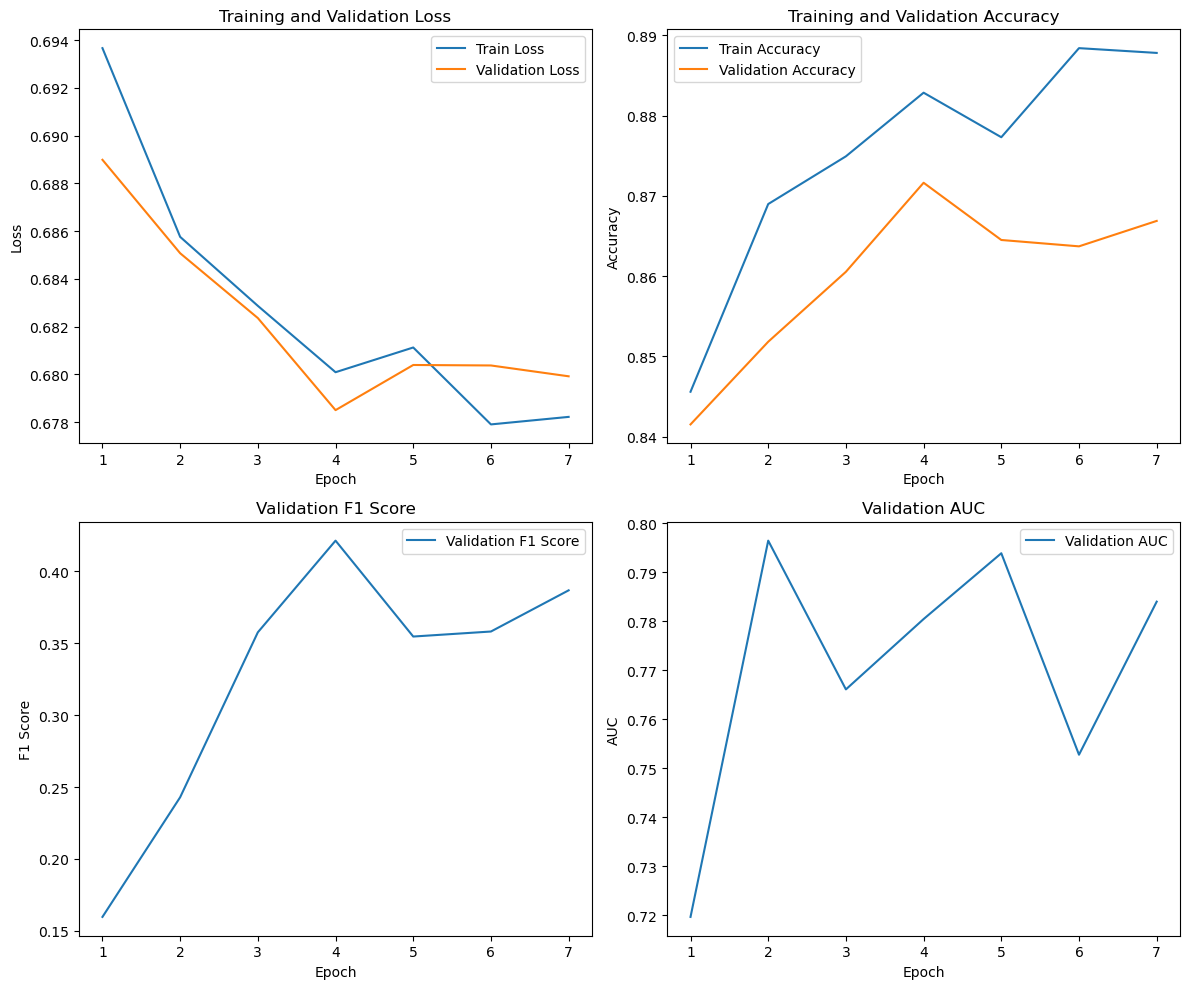

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6785
fold,2
val_accuracy,0.8645
val_auc,0.77153
val_f1,0.37363


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6948, Val Loss = 0.6879, Train Acc = 0.8393, Val Acc = 0.8604, Val F1 = 0.2903, Val AUC = 0.7286
Epoch 2: Train Loss = 0.6873, Val Loss = 0.6836, Train Acc = 0.8593, Val Acc = 0.8707, Val F1 = 0.3608, Val AUC = 0.8012
Epoch 3: Train Loss = 0.6832, Val Loss = 0.6810, Train Acc = 0.8712, Val Acc = 0.8787, Val F1 = 0.4270, Val AUC = 0.8295
Epoch 4: Train Loss = 0.6811, Val Loss = 0.6777, Train Acc = 0.8769, Val Acc = 0.8858, Val F1 = 0.4627, Val AUC = 0.8263
Epoch 5: Train Loss = 0.6794, Val Loss = 0.6792, Train Acc = 0.8839, Val Acc = 0.8953, Val F1 = 0.6000, Val AUC = 0.8532
Epoch 6: Train Loss = 0.6797, Val Loss = 0.6788, Train Acc = 0.8821, Val Acc = 0.8842, Val F1 = 0.4748, Val AUC = 0.8081
Epoch 7: Train Loss = 0.6792, Val Loss = 0.6960, Train Acc = 0.8847, Val Acc = 0.8763, Val F1 = 0.6195, Val AUC = 0.8442


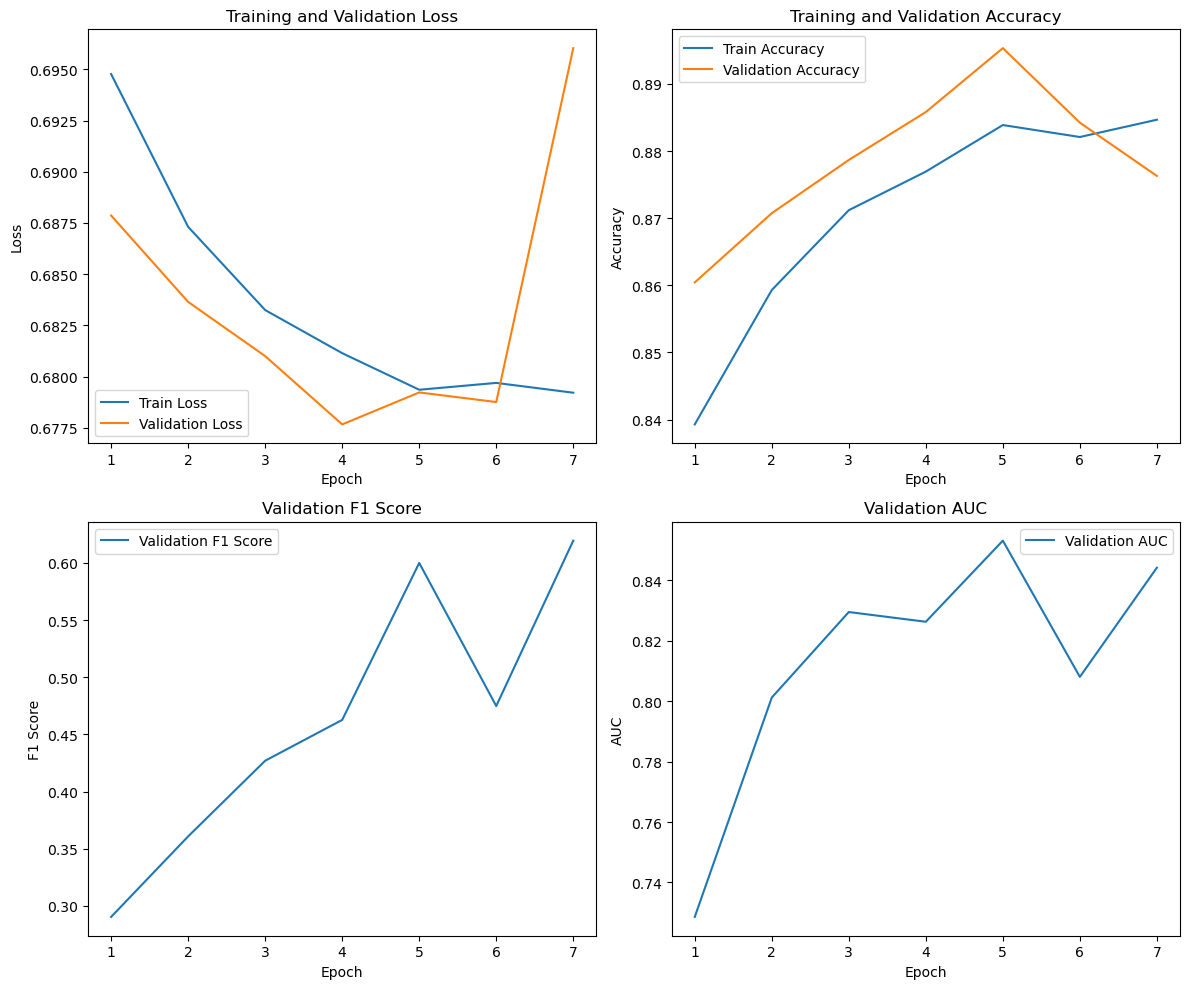

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67766
fold,3
val_accuracy,0.8747
val_auc,0.85868
val_f1,0.6165


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6930, Val Loss = 0.6958, Train Acc = 0.8446, Val Acc = 0.8557, Val F1 = 0.3974, Val AUC = 0.7609
Epoch 2: Train Loss = 0.6834, Val Loss = 0.6877, Train Acc = 0.8730, Val Acc = 0.8739, Val F1 = 0.4984, Val AUC = 0.8428
Epoch 3: Train Loss = 0.6779, Val Loss = 0.6787, Train Acc = 0.8872, Val Acc = 0.8842, Val F1 = 0.4931, Val AUC = 0.8646
Epoch 4: Train Loss = 0.6725, Val Loss = 0.6812, Train Acc = 0.9025, Val Acc = 0.8723, Val F1 = 0.3429, Val AUC = 0.8557
Epoch 5: Train Loss = 0.6715, Val Loss = 0.6766, Train Acc = 0.9031, Val Acc = 0.8961, Val F1 = 0.5944, Val AUC = 0.9015
Epoch 6: Train Loss = 0.6686, Val Loss = 0.6814, Train Acc = 0.9136, Val Acc = 0.8921, Val F1 = 0.6092, Val AUC = 0.9036
Epoch 7: Train Loss = 0.6702, Val Loss = 0.6762, Train Acc = 0.9086, Val Acc = 0.9025, Val F1 = 0.6455, Val AUC = 0.9027
Epoch 8: Train Loss = 0.6669, Val Loss = 0.6777, Train Acc = 0.9162, Val Acc = 0.8858, Val F1 = 0.4627, Val AUC = 0.8978
Epo

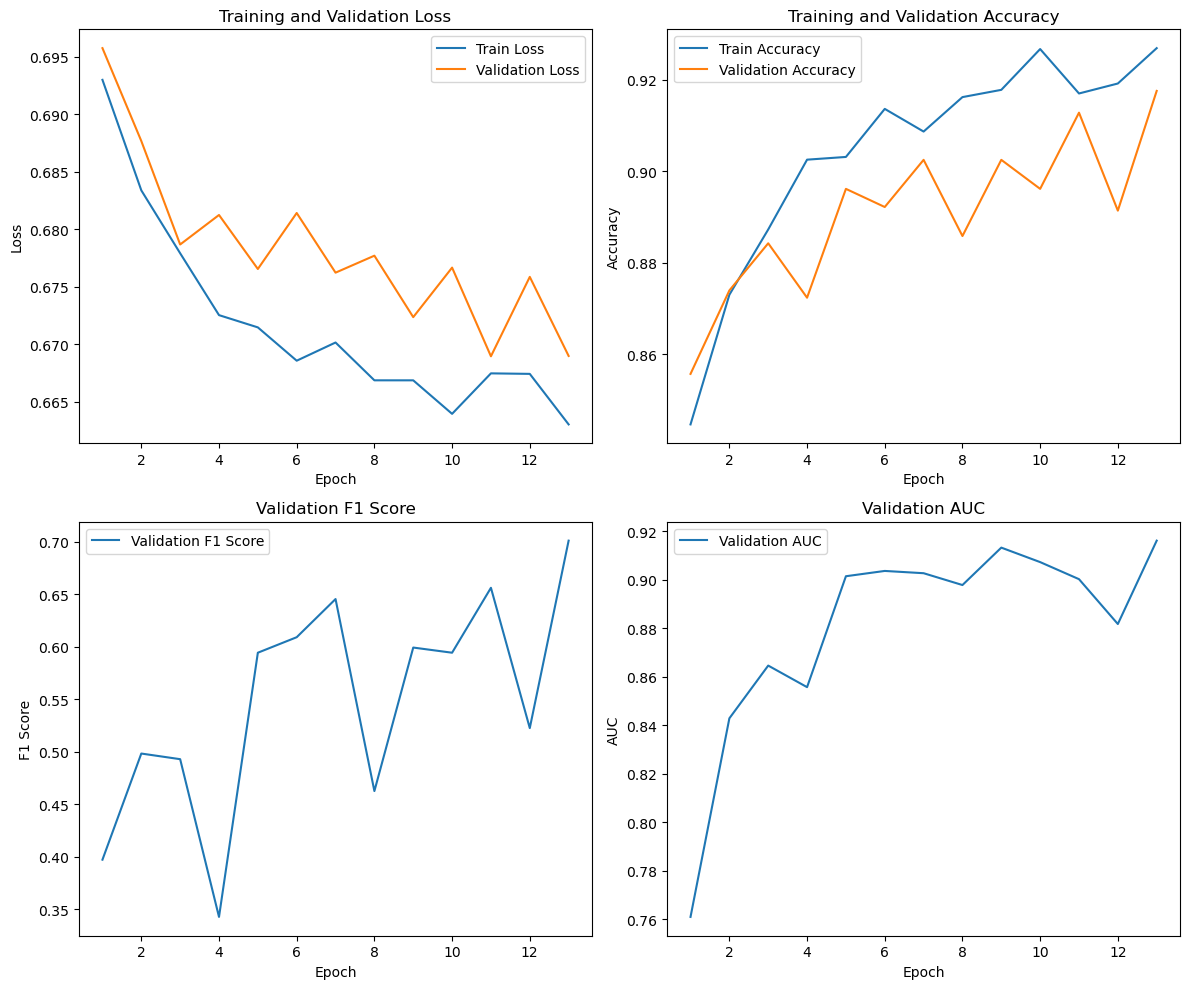

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66896
fold,4
val_accuracy,0.91673
val_auc,0.90361
val_f1,0.69565


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6945, Val Loss = 0.6931, Train Acc = 0.8411, Val Acc = 0.8422, Val F1 = 0.0000, Val AUC = 0.7455
Epoch 2: Train Loss = 0.6874, Val Loss = 0.6792, Train Acc = 0.8597, Val Acc = 0.8826, Val F1 = 0.4436, Val AUC = 0.8392
Epoch 3: Train Loss = 0.6792, Val Loss = 0.6788, Train Acc = 0.8837, Val Acc = 0.8803, Val F1 = 0.3984, Val AUC = 0.8450
Epoch 4: Train Loss = 0.6773, Val Loss = 0.6856, Train Acc = 0.8882, Val Acc = 0.8929, Val F1 = 0.6617, Val AUC = 0.8887
Epoch 5: Train Loss = 0.6752, Val Loss = 0.6719, Train Acc = 0.8932, Val Acc = 0.9128, Val F1 = 0.6802, Val AUC = 0.9048
Epoch 6: Train Loss = 0.6735, Val Loss = 0.6730, Train Acc = 0.8971, Val Acc = 0.8985, Val F1 = 0.5586, Val AUC = 0.9054
Epoch 7: Train Loss = 0.6695, Val Loss = 0.6655, Train Acc = 0.9104, Val Acc = 0.9199, Val F1 = 0.6752, Val AUC = 0.9149
Epoch 8: Train Loss = 0.6658, Val Loss = 0.6677, Train Acc = 0.9184, Val Acc = 0.9136, Val F1 = 0.6472, Val AUC = 0.9214
Epo

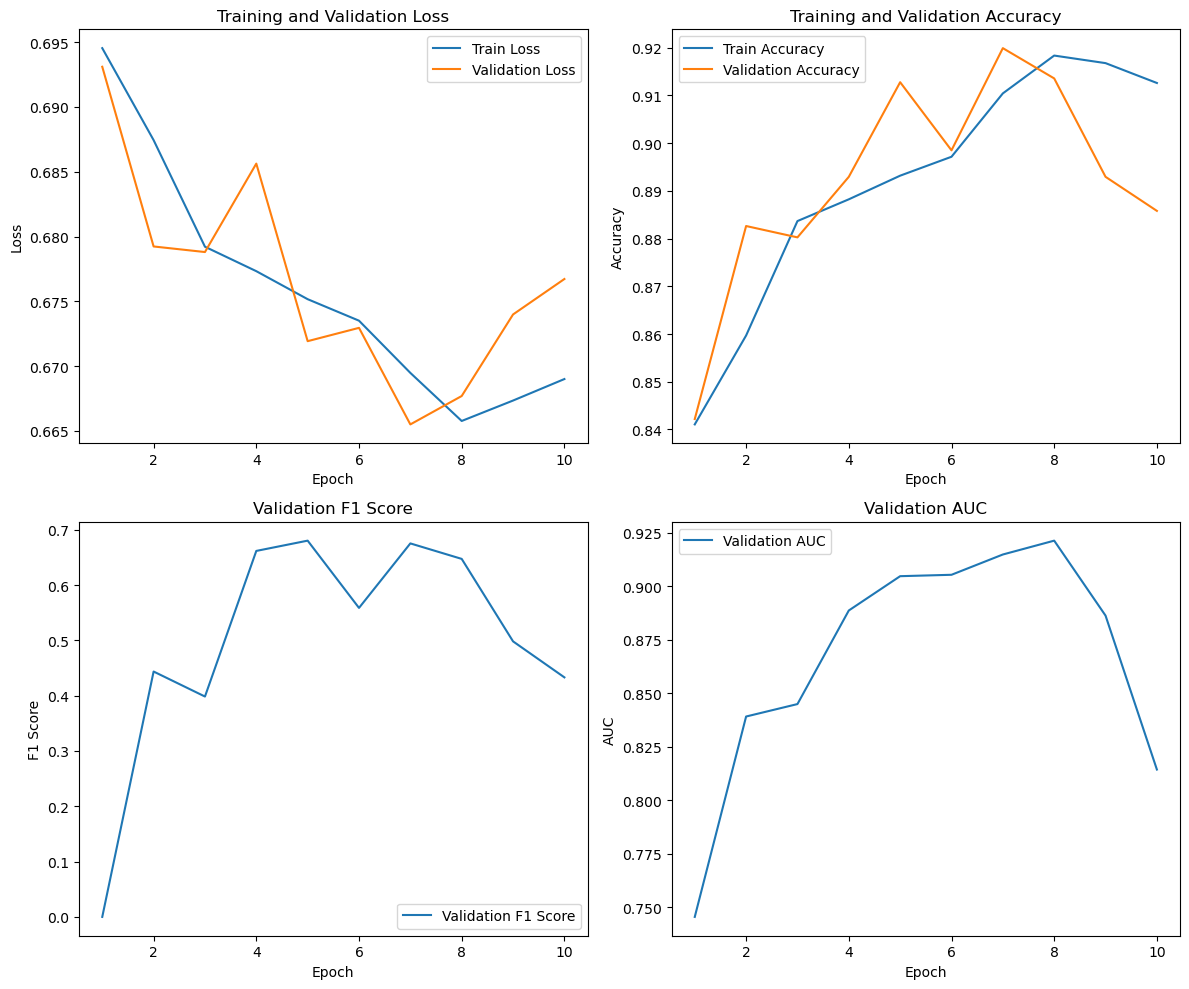

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6655
fold,5
val_accuracy,0.88422
val_auc,0.81846
val_f1,0.4252


In [6]:
patience = 2
k_folds = 5  
epochs=13


learning_rate=0.000022012211629918463
weight_decay=0.000001549668920821374
batch_size = 4


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_losses = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model_VGG19 = VanGoghModel(device,None,'VGG19').model

    optimizer_VGG19 = optim.Adam(model_VGG19.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_VGG19 = nn.BCEWithLogitsLoss()

    wandb.init(
        project="Train_VGG19",
        config={
            "model": "VGG19",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"VGG19_fold_{fold+1}"
    )

    best_val_loss_VGG19 = train_model_with_hyperparams(
        model_VGG19, train_loader, val_loader, optimizer_VGG19, criterion_VGG19,
        epochs=epochs, patience=patience
    )
    
    fold_losses.append(best_val_loss_VGG19)
    
    model_VGG19.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_VGG19(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    
    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

   

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_VGG19,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()






***Train AlexNet***

--- Fold 1/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6888, Val Loss = 0.6803, Train Acc = 0.8579, Val Acc = 0.8883, Val F1 = 0.4556, Val AUC = 0.7929
Epoch 2: Train Loss = 0.6797, Val Loss = 0.6803, Train Acc = 0.8793, Val Acc = 0.8859, Val F1 = 0.4240, Val AUC = 0.8301
Epoch 3: Train Loss = 0.6768, Val Loss = 0.6788, Train Acc = 0.8878, Val Acc = 0.8883, Val F1 = 0.4382, Val AUC = 0.8202
Epoch 4: Train Loss = 0.6752, Val Loss = 0.6770, Train Acc = 0.8916, Val Acc = 0.8986, Val F1 = 0.5429, Val AUC = 0.8522
Epoch 5: Train Loss = 0.6731, Val Loss = 0.6761, Train Acc = 0.8953, Val Acc = 0.9025, Val F1 = 0.5831, Val AUC = 0.8633
Epoch 6: Train Loss = 0.6726, Val Loss = 0.6710, Train Acc = 0.8999, Val Acc = 0.9128, Val F1 = 0.6284, Val AUC = 0.8793
Epoch 7: Train Loss = 0.6723, Val Loss = 0.6734, Train Acc = 0.9019, Val Acc = 0.9120, Val F1 = 0.6454, Val AUC = 0.9125
Epoch 8: Train Loss = 0.6693, Val Loss = 0.6783, Train Acc = 0.9088, Val Acc = 0.9033, Val F1 = 0.6303, Val AUC = 0.8948
Epo

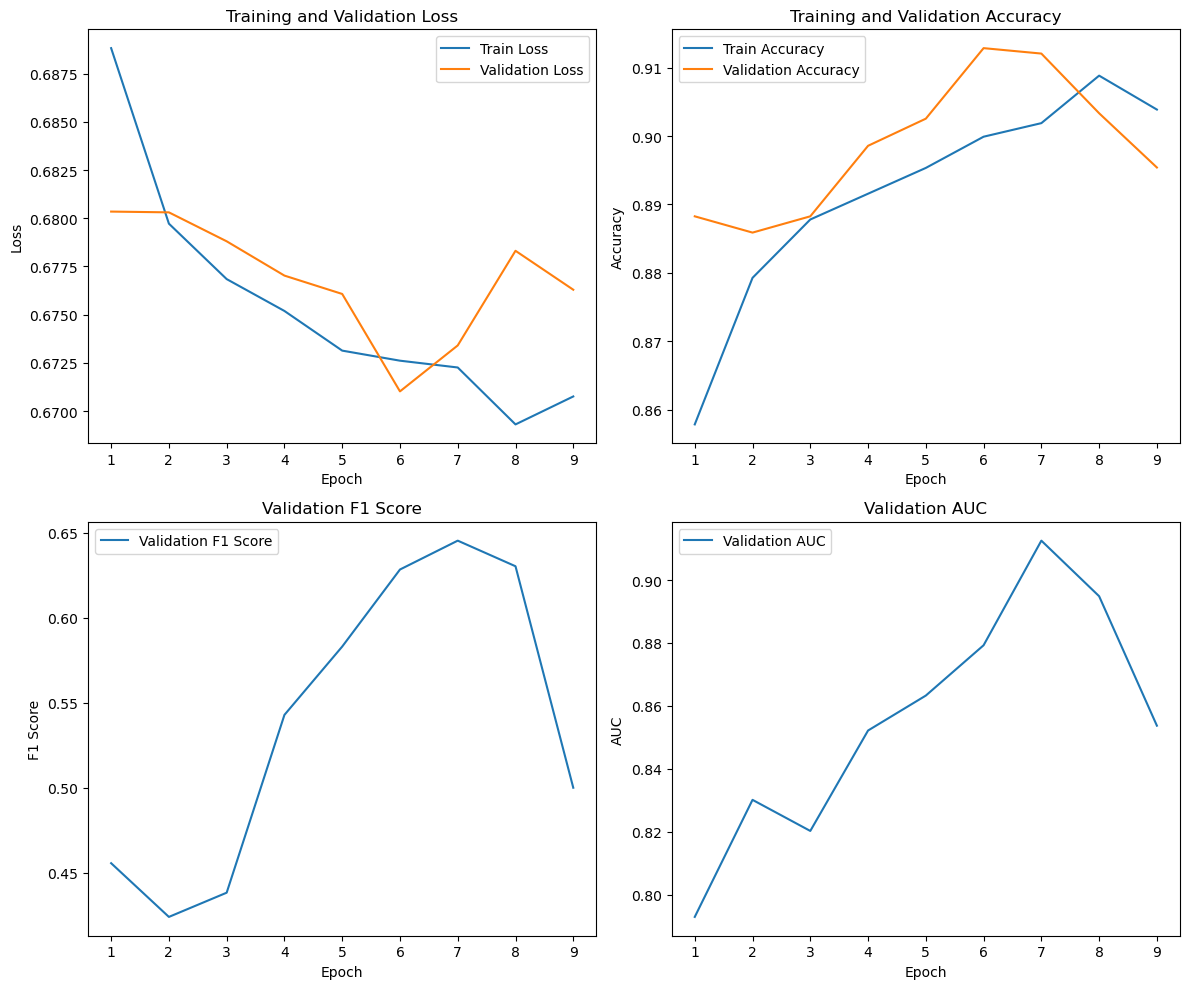

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67102
fold,1
val_accuracy,0.8962
val_auc,0.85784
val_f1,0.50566


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6883, Val Loss = 0.6779, Train Acc = 0.8644, Val Acc = 0.8724, Val F1 = 0.4145, Val AUC = 0.7813
Epoch 2: Train Loss = 0.6787, Val Loss = 0.6808, Train Acc = 0.8852, Val Acc = 0.8772, Val F1 = 0.5289, Val AUC = 0.7995
Epoch 3: Train Loss = 0.6775, Val Loss = 0.6737, Train Acc = 0.8922, Val Acc = 0.8891, Val F1 = 0.5652, Val AUC = 0.8497
Epoch 4: Train Loss = 0.6745, Val Loss = 0.6753, Train Acc = 0.8973, Val Acc = 0.8811, Val F1 = 0.5130, Val AUC = 0.8657
Epoch 5: Train Loss = 0.6723, Val Loss = 0.6760, Train Acc = 0.9051, Val Acc = 0.8756, Val F1 = 0.4413, Val AUC = 0.8479
Epoch 6: Train Loss = 0.6717, Val Loss = 0.6719, Train Acc = 0.9060, Val Acc = 0.8906, Val F1 = 0.5687, Val AUC = 0.8697
Epoch 7: Train Loss = 0.6713, Val Loss = 0.6959, Train Acc = 0.9076, Val Acc = 0.8716, Val F1 = 0.6509, Val AUC = 0.8756
Epoch 8: Train Loss = 0.6696, Val Loss = 0.6712, Train Acc = 0.9120, Val Acc = 0.8914, Val F1 = 0.5759, Val AUC = 0.8906
Epo

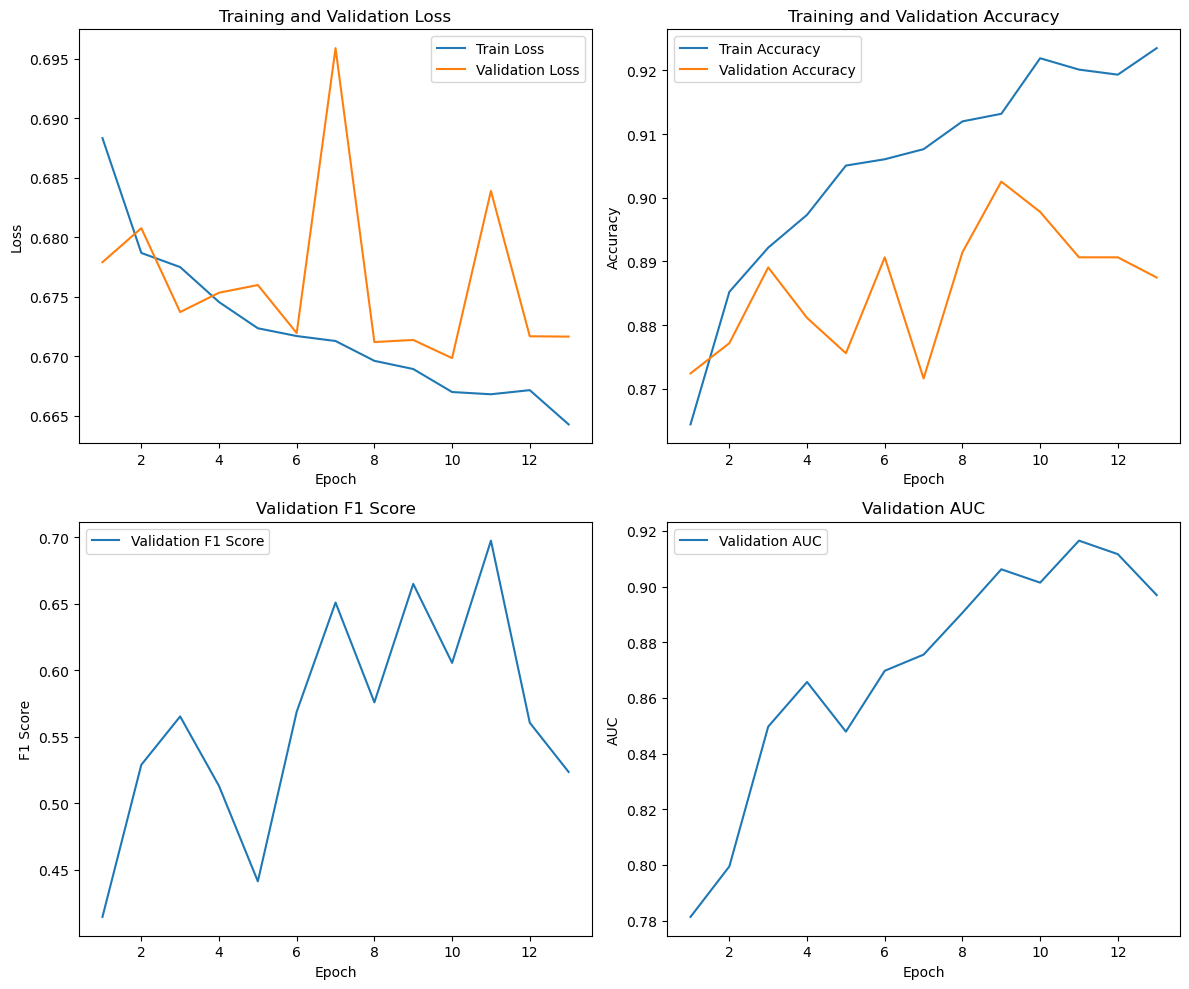

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66984
fold,2
val_accuracy,0.88906
val_auc,0.90165
val_f1,0.53333


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6871, Val Loss = 0.6959, Train Acc = 0.8625, Val Acc = 0.8803, Val F1 = 0.6326, Val AUC = 0.8900
Epoch 2: Train Loss = 0.6790, Val Loss = 0.6716, Train Acc = 0.8835, Val Acc = 0.9064, Val F1 = 0.6242, Val AUC = 0.9176
Epoch 3: Train Loss = 0.6745, Val Loss = 0.6769, Train Acc = 0.8964, Val Acc = 0.8858, Val F1 = 0.4419, Val AUC = 0.9324
Epoch 4: Train Loss = 0.6702, Val Loss = 0.6709, Train Acc = 0.9084, Val Acc = 0.9040, Val F1 = 0.5953, Val AUC = 0.9411
Epoch 5: Train Loss = 0.6695, Val Loss = 0.6751, Train Acc = 0.9100, Val Acc = 0.9136, Val F1 = 0.7046, Val AUC = 0.9370
Epoch 6: Train Loss = 0.6670, Val Loss = 0.6657, Train Acc = 0.9164, Val Acc = 0.9183, Val F1 = 0.6751, Val AUC = 0.9468
Epoch 7: Train Loss = 0.6657, Val Loss = 0.6651, Train Acc = 0.9193, Val Acc = 0.9262, Val F1 = 0.7289, Val AUC = 0.9435
Epoch 8: Train Loss = 0.6654, Val Loss = 0.6657, Train Acc = 0.9187, Val Acc = 0.9247, Val F1 = 0.7278, Val AUC = 0.9456
Epo

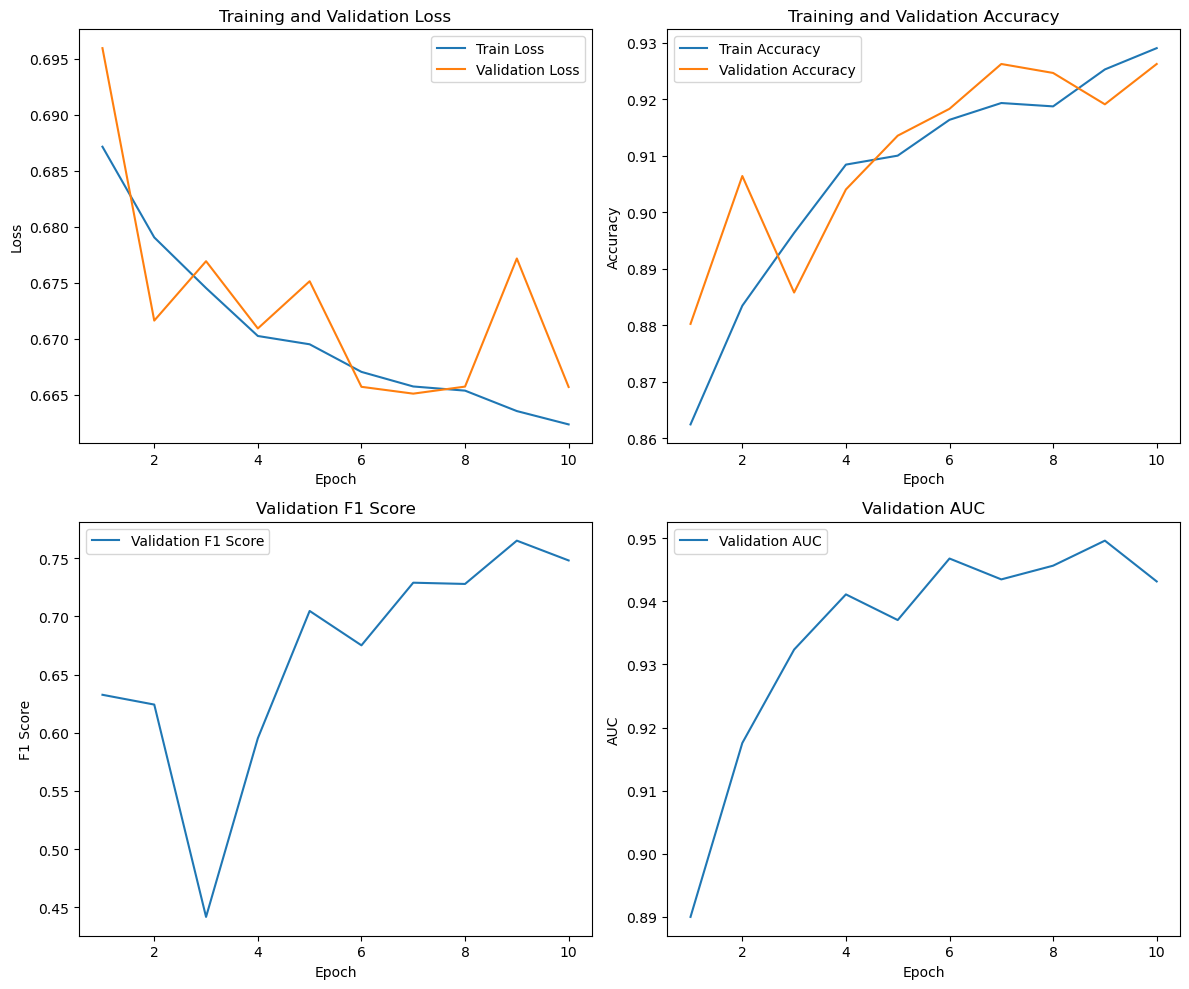

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6651
fold,3
val_accuracy,0.9318
val_auc,0.94439
val_f1,0.76503


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6903, Val Loss = 0.6868, Train Acc = 0.8549, Val Acc = 0.8588, Val F1 = 0.2124, Val AUC = 0.7211
Epoch 2: Train Loss = 0.6781, Val Loss = 0.6791, Train Acc = 0.8874, Val Acc = 0.8803, Val F1 = 0.4170, Val AUC = 0.8013
Epoch 3: Train Loss = 0.6775, Val Loss = 0.6772, Train Acc = 0.8864, Val Acc = 0.8866, Val F1 = 0.4911, Val AUC = 0.8217
Epoch 4: Train Loss = 0.6767, Val Loss = 0.6774, Train Acc = 0.8914, Val Acc = 0.8921, Val F1 = 0.5497, Val AUC = 0.8611
Epoch 5: Train Loss = 0.6727, Val Loss = 0.6757, Train Acc = 0.9013, Val Acc = 0.8890, Val F1 = 0.4737, Val AUC = 0.8591
Epoch 6: Train Loss = 0.6701, Val Loss = 0.6757, Train Acc = 0.9084, Val Acc = 0.8906, Val F1 = 0.4964, Val AUC = 0.8672
Epoch 7: Train Loss = 0.6702, Val Loss = 0.6736, Train Acc = 0.9057, Val Acc = 0.8945, Val F1 = 0.5128, Val AUC = 0.8713
Epoch 8: Train Loss = 0.6679, Val Loss = 0.6762, Train Acc = 0.9126, Val Acc = 0.9017, Val F1 = 0.6353, Val AUC = 0.8843
Epo

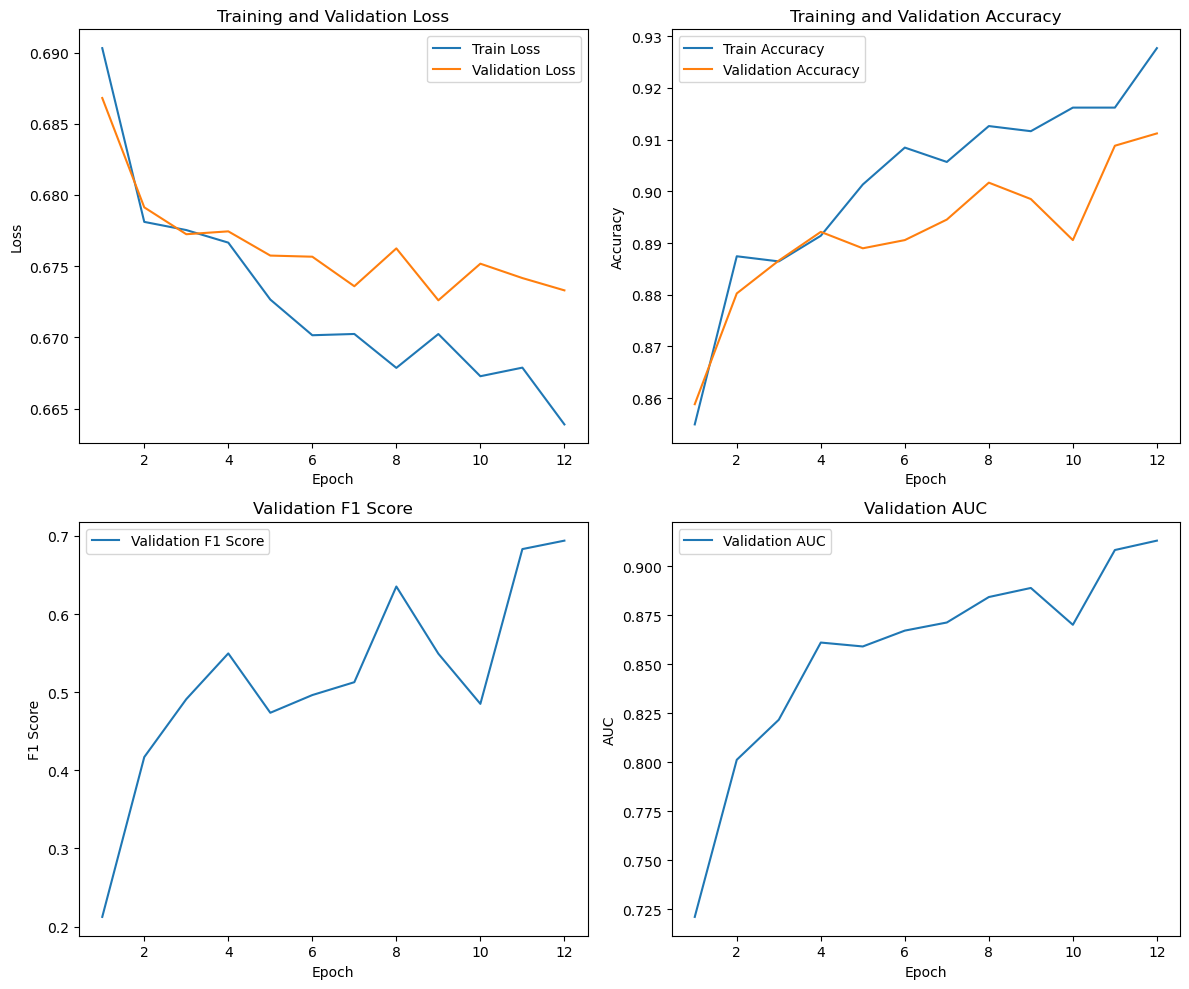

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6726
fold,4
val_accuracy,0.91039
val_auc,0.90764
val_f1,0.69377


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6881, Val Loss = 0.6804, Train Acc = 0.8613, Val Acc = 0.8763, Val F1 = 0.3760, Val AUC = 0.8350
Epoch 2: Train Loss = 0.6778, Val Loss = 0.6749, Train Acc = 0.8864, Val Acc = 0.8929, Val F1 = 0.5126, Val AUC = 0.8727
Epoch 3: Train Loss = 0.6760, Val Loss = 0.6741, Train Acc = 0.8926, Val Acc = 0.8945, Val F1 = 0.5267, Val AUC = 0.8864
Epoch 4: Train Loss = 0.6730, Val Loss = 0.6765, Train Acc = 0.8987, Val Acc = 0.8866, Val F1 = 0.4436, Val AUC = 0.8779
Epoch 5: Train Loss = 0.6740, Val Loss = 0.6676, Train Acc = 0.8993, Val Acc = 0.9159, Val F1 = 0.6728, Val AUC = 0.9204
Epoch 6: Train Loss = 0.6707, Val Loss = 0.6771, Train Acc = 0.9071, Val Acc = 0.8858, Val F1 = 0.4419, Val AUC = 0.8936
Epoch 7: Train Loss = 0.6692, Val Loss = 0.6679, Train Acc = 0.9092, Val Acc = 0.9167, Val F1 = 0.6866, Val AUC = 0.9309
Epoch 8: Train Loss = 0.6653, Val Loss = 0.6684, Train Acc = 0.9209, Val Acc = 0.9128, Val F1 = 0.6452, Val AUC = 0.9229


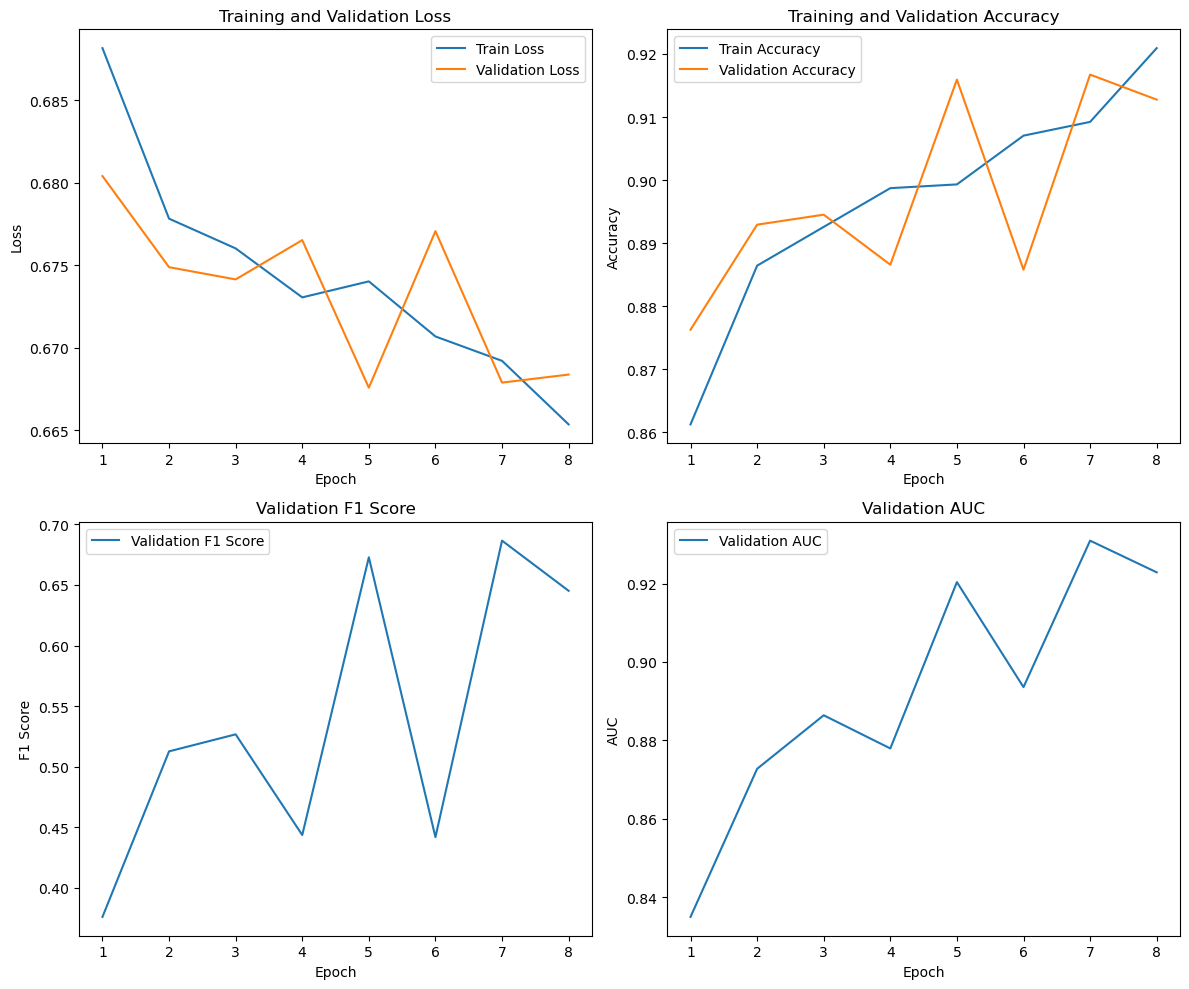

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66757
fold,5
val_accuracy,0.91594
val_auc,0.92718
val_f1,0.65132


In [7]:
patience = 2
k_folds = 5  
epochs=13

batch_size = 8
weight_decay = 1.2852718112074654e-05
learning_rate=3.020842532706549e-05


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_losses = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model_Alex = VanGoghModel(device,None,'AlexNet').model
 
    optimizer_AlexNet = optim.Adam(model_Alex.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_AlexNet = nn.BCEWithLogitsLoss()

    wandb.init(
        project="Train_AlexNet",
        config={
            "model": "AlexNet",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"Train_AlexNet{fold+1}"
    )

    best_val_loss_AlexNet = train_model_with_hyperparams(
        model_Alex, train_loader, val_loader, optimizer_AlexNet, criterion_AlexNet, epochs=epochs, patience=patience
    )

    fold_losses.append(best_val_loss_AlexNet)

 
    model_Alex.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_Alex(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_AlexNet,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()


